# Part 1

In [65]:
%matplotlib notebook

import matplotlib.pyplot as plt

In [63]:
# Created in day 16, updated in day 19, and updated again here:
import functools
import operator

class CpuHalt(Exception):
    pass

class Cpu:
    def __init__(self, registers):
        self._registers = registers
        self._ip = 0
        self._ip_register = None
        self._program = None
        self._count = 0

    @property
    def count(self):
        return self._count

    @property
    def registers(self):
        return tuple(self._registers)

    def program(self, text):
        ''' Parse program text and insert it into this CPU. '''
        lines = text.strip().split('\n')
        program = list()
        ip_register = None
        for line in lines:
            if line.startswith('#ip'):
                _, reg = line.split()
                self._ip_register = int(reg)
            else: 
                insn, a, b, c = line.split()
                program.append((insn, int(a), int(b), int(c)))
        self._program = program

    def step(self, debug=False):
        ''' Run next instruction and update IP. '''
        try:
            instruction = self._program[self._ip]
        except IndexError:
            raise CpuHalt() 
        self._registers[self._ip_register] = self._ip
        if debug:
            before = self.registers
        op = getattr(self, instruction[0])
        op(*instruction[1:4])
        if debug:
            after = self.registers
            print('ip={:<3d} {} {} {}'.format(self._ip, before, instruction, after))
        self._ip = self._registers[self._ip_register]
        self._ip += 1
    
    def run(self, n=10_000_000, debug=False, breakpoint=None):
        ''' Run up to n iterations or until the CPU halts, i.e. the IP 
        points to a non-existent instruction. '''
        try:
            for _ in range(n):
                self.step(debug)
                self._count += 1
                if self._ip == breakpoint:
                    print('Stopped at breakpoint: {}'.format(breakpoint))
                    return
            print('Finished running {} steps.'.format(n))
        except CpuHalt:
            print('CPU halted. Registers={}'.format(self.registers))
    
    def _do_op_imm(self, op, a, b, c):
        self._registers[c] = op(self._registers[a], b)
        
    def _do_op_reg(self, op, a, b, c):
        self._registers[c] = op(self._registers[a], self._registers[b])

    addi = functools.partialmethod(_do_op_imm, operator.add)
    addr = functools.partialmethod(_do_op_reg, operator.add)
    muli = functools.partialmethod(_do_op_imm, operator.mul)
    mulr = functools.partialmethod(_do_op_reg, operator.mul)
    bani = functools.partialmethod(_do_op_imm, operator.and_)
    banr = functools.partialmethod(_do_op_reg, operator.and_)
    bori = functools.partialmethod(_do_op_imm, operator.or_)
    borr = functools.partialmethod(_do_op_reg, operator.or_)

    def _do_cmp_reg_imm(self, cmp, a, b, c):
        self._registers[c] = int(cmp(self._registers[a], b))
        
    def _do_cmp_imm_reg(self, cmp, a, b, c):
        self._registers[c] = int(cmp(a, self._registers[b]))

    def _do_cmp_reg_reg(self, cmp, a, b, c):
        self._registers[c] = int(cmp(self._registers[a], self._registers[b]))

    gtir = functools.partialmethod(_do_cmp_imm_reg, operator.gt)
    gtri = functools.partialmethod(_do_cmp_reg_imm, operator.gt)
    gtrr = functools.partialmethod(_do_cmp_reg_reg, operator.gt)
    eqir = functools.partialmethod(_do_cmp_imm_reg, operator.eq)
    eqri = functools.partialmethod(_do_cmp_reg_imm, operator.eq)
    eqrr = functools.partialmethod(_do_cmp_reg_reg, operator.eq)

    def seti(self, a, b, c):    
        self._registers[c] = a
        
    def setr(self, a, b, c):
        self._registers[c] = self._registers[a]

In [12]:
with open('input.txt') as input_:
    program_text = input_.read()

In [15]:
def check_val(val):
    ''' Initialize CPU with val in register 0 and then run it. '''
    cpu = Cpu([val,0,0,0,0,0])
    cpu.program(program_text)
    cpu.run()
    print('Instruction count', cpu.count)

In [17]:
%%time
check_val(0)

Finished running 10000000 steps.
Instruction count 10000000
CPU times: user 23.7 s, sys: 27.4 ms, total: 23.7 s
Wall time: 23.7 s


In [18]:
%%time
check_val(1)

Finished running 10000000 steps.
Instruction count 10000000
CPU times: user 23.9 s, sys: 29.8 ms, total: 23.9 s
Wall time: 24 s


Hmm... It doesn't seem like its going to halt on 0 or 1. Time to start reversing. I'll give the registers names again.

    0 1 2  3 4 5
    A B IP C D E

Here's the program text cleaned up and converted to pseudocode. This program relies
heavily on bitwise operations, so I've also converted some decimal values to base16
for easier reading.

    testbug: // This is the test for bitwise bug described in the problem
     
     0  E = 123
     1  E &= 456
     2  E = (E==72) ? 1 : 0
     3  IP += E            // If 123 & 456 == 72, then jump to 5 (main)
     4  IP = 0             // Jump to 1
     
    main:
     
     5  E = 0
     6  D = E | 65536 (0x10000)  // D = E with bit 5 set
     7  E = 15466939 (0xEC01BB)
     8  C = D & 255 (0xFF)       // C = lower byte of D
     9  E += C
    10  E &= 16777215 (0xFFFFFF) // Set top byte of E to 0
    11  E *= 65899 (0x1016B)
    12  E &= 16777215
    13  C = (256 > D) ? 1 : 0
    14  IP += C            // If D < 256, then jump to 16 
    15  IP += 1            // Jump to 17 (sub1)
    16  IP = 27            // Jump to 28 (cond_halt)
    
    sub1:

    17  C = 0 
    18  B = C + 1
    19  B *= 256
    20  B = (B > D) ? 1 : 0
    21  IP += B            // If B > D, then jump to 23
    22  IP += 1            // Jump to 24
    23  IP = 25            // Jump to 26
    24  C += 1
    25  IP = 17            // Jump to 18
    26  D = C
    27  IP = 7             // Jump to 8
    
    cond_halt:
    
    28  C = (A == E) ? 1 : 0
    29  IP += C            // If A==E, jump to 31 (HALT!)
    30  IP = 5             // Jump to 6

The program code shows that we need the condition A == E in order for the program
to halt (28-29). A is the only register we are allowed to set, and it is not modified
by the program. So we need to figure out what E will be at line 28 and set A to it.

Instead of continuing to reverse the program, I'm going to modify the CPU to set a
breakpoint on line 28. Then we can just print out the registers and see what E is.

In [23]:
# First, check to make sure that the CPU is correctly executing the bani instruction
# as described in the problem. We can tell by tracing the first 5 steps of the
# program. If we have the bug, step 5 will be ip=1. If we do not have the bug,
# step 5 will be ip=5.
test_cpu = Cpu([0,0,0,0,0,0])
test_cpu.program(program_text)
test_cpu.run(n=5, debug=True)
print('Instruction count', test_cpu.count)

ip=0   (0, 0, 0, 0, 0, 0) ('seti', 123, 0, 5) (0, 0, 0, 0, 0, 123)
ip=1   (0, 0, 1, 0, 0, 123) ('bani', 5, 456, 5) (0, 0, 1, 0, 0, 72)
ip=2   (0, 0, 2, 0, 0, 72) ('eqri', 5, 72, 5) (0, 0, 2, 0, 0, 1)
ip=3   (0, 0, 3, 0, 0, 1) ('addr', 5, 2, 2) (0, 0, 4, 0, 0, 1)
ip=5   (0, 0, 5, 0, 0, 1) ('seti', 0, 4, 5) (0, 0, 5, 0, 0, 0)
Finished running 5 steps.
Instruction count 5


In [27]:
# See if we can get the CPU to break at line 28.
test_cpu = Cpu([0,0,0,0,0,0])
test_cpu.program(program_text)
test_cpu.run(breakpoint=28)

Stopped at breakpoint: 28


In [28]:
test_cpu.registers

(0, 1, 27, 1, 1, 15615244)

In [29]:
test_cpu.count

1846

In [30]:
# If we use the value in E as the initial value of A, it should cause the CPU to halt.
check_val(15615244)

CPU halted. Registers=(15615244, 1, 30, 1, 1, 15615244)
Instruction count 1848


# Part 2

In [35]:
# I could try more reversing to solve part 2, but I think there might be a shortcut.
# I am guessing the the value of E will eventually repeat, and when it does, the last
# item before it repeats is the answer to part 2.
test_cpu = Cpu([0,0,0,0,0,0])
test_cpu.program(program_text)
e_register = list()
for _ in range(250):
    test_cpu.run(breakpoint=28)
    e_register.append(test_cpu.registers[5])

In [52]:
# Did any values repeat?
from collections import Counter
e_counter = Counter(e_register)
print('breakpoint hit={}, cpu count={}'.format(len(e_register), test_cpu.count))
e_counter.most_common(5)

breakpoint hit=250, cpu count=59833490


[(15615244, 1), (5285447, 1), (11113847, 1), (9646982, 1), (1372767, 1)]

<IPython.core.display.Javascript object>


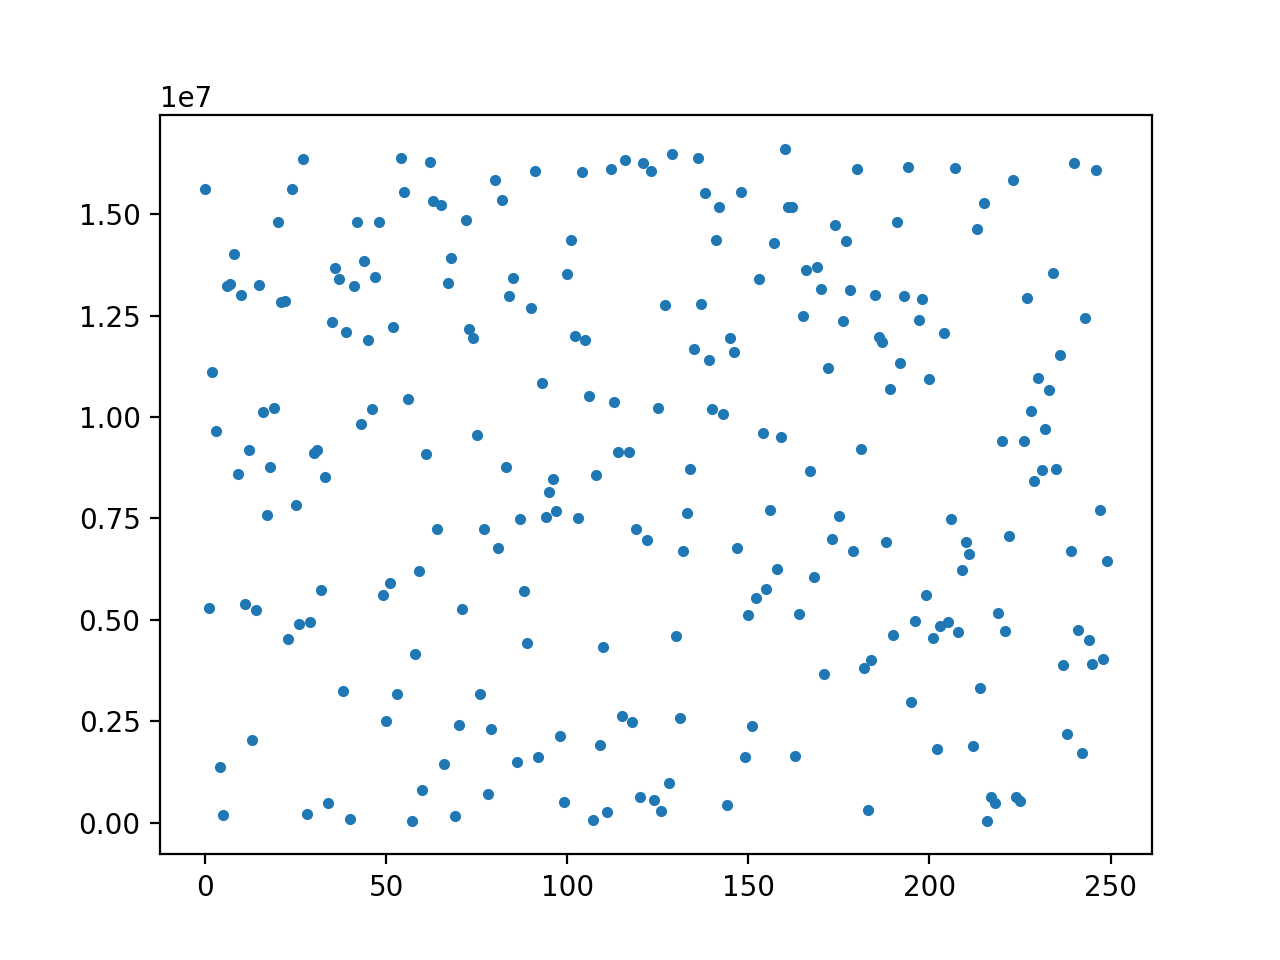

In [69]:
# Hmm, after collecting 250 values of E and running 60M instructions, the values 
# of E haven't repeated once! I'll plot the values and see if there is any discernible
# pattern.
plt.plot(e_register, marker='.', linestyle='none')

In [82]:
# The plot looks very random. I suspect that this program is a kind of pseudo
# random number generator. If this is the case, it could have a very long period
# (millions of values) before it repeats. It might be more efficient to rewrite
# the program in Python and compute values of E directly.
def compute_e(n):
    e_values = list()
    E = 0
    D = E | 65536 # Line 6
    E = 15466939
    while len(e_values) < n:
        C = D & 255          # Line 8
        E += C
        E &= 16777215        # Mask with 0xFFFFFF
        E *= 65899
        E &= 16777215        # Mask with 0xFFFFFF      
        if D < 256:
            # The real program checks if A==E, but we just want to record
            # what E was, as if we had set a breakpoint here and printed
            # out the E register.
            e_values.append(E)
            # We need to goto 6 now. Since Python doesn't have goto, we'll
            # execute lines 6 and 7 and then jump to 8.
            D = E | 65536
            E = 15466939
            continue
        else:
            C = 0            # Line 17
            while True:
                B = C + 1    # Line 18
                B *= 256
                if B > D:
                    D = C
                    break    # Jump 8
                else: 
                    C += 1
                    continue # Jump 18

    return e_values

In [83]:
# Compare first 10 items from my Python program with the first 10 items from the emulated program.
e_register[:10]

[15615244,
 5285447,
 11113847,
 9646982,
 1372767,
 177943,
 13239702,
 13273529,
 14028918,
 8597072]

In [85]:
compute_e(10)

[15615244,
 5285447,
 11113847,
 9646982,
 1372767,
 177943,
 13239702,
 13273529,
 14028918,
 8597072]

In [86]:
%%time
assert e_register[:250] == compute_e(250)

CPU times: user 1.27 s, sys: 2.87 ms, total: 1.28 s
Wall time: 1.28 s


In [90]:
%%time
# Great, now we have a Python implementation of the program that is 
# much faster than the emulated version. Let's generate 10,000 values
# of E.
e_register = compute_e(10_000)

CPU times: user 48.2 s, sys: 89.4 ms, total: 48.3 s
Wall time: 48.3 s


In [88]:
# Any repeats?
e_counter = Counter(e_register)
e_counter.most_common(5)

[(15615244, 1), (5285447, 1), (11113847, 1), (9646982, 1), (1372767, 1)]

<IPython.core.display.Javascript object>


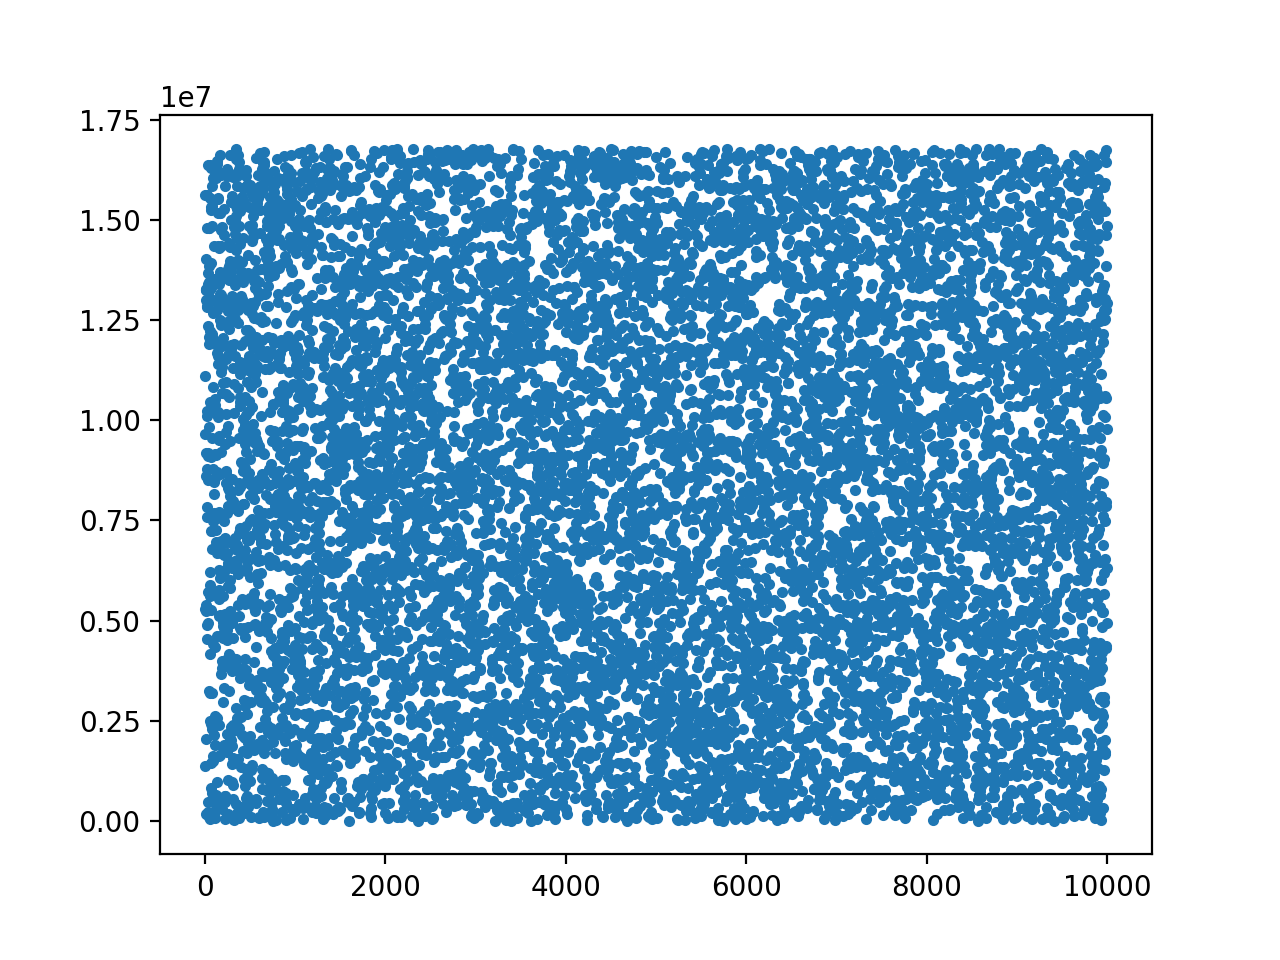

In [89]:
# Any pattern in the plot?
plt.plot(e_register, marker='.', linestyle='none')

In [97]:
# Hmm, no repeats after 50,000. The program masks off E so it can never
# become larger than 16,777,215, so we'll get at least 1 repeat if we
# collect that many values. This doesn't guarantee that the period of 
# this function isn't much, much larger, but it's worth a shot. This
# will be very slow but is doable (worst case ~5 hours).
def compute_repeat():
    e_values = set()
    last_e = None
    E = 0
    D = E | 65536 # Line 6
    E = 15466939
    for n in range(16777216):
        if n % 50000 == 0:
            print('iterations={}'.format(n))
        C = D & 255          # Line 8
        E += C
        E &= 16777215        # Mask with 0xFFFFFF
        E *= 65899
        E &= 16777215        # Mask with 0xFFFFFF      
        if D < 256:
            # The real program checks if A==E, but we just want to record
            # what E was, as if we had set a breakpoint here and printed
            # out the E register.
            if E in e_values:
                print('iterations={}\nRepeated value! E={}'.format(n, E))
                print('Last value was {}'.format(last_e))
                return
            else:
                e_values.add(E)
                last_e = E
            # We need to goto 6 now. Since Python doesn't have goto, we'll
            # execute lines 6 and 7 and then jump to 8.
            D = E | 65536
            E = 15466939
            continue
        else:
            C = 0            # Line 17
            while True:
                B = C + 1    # Line 18
                B *= 256
                if B > D:
                    D = C
                    break    # Jump 8
                else: 
                    C += 1
                    continue # Jump 18

In [98]:
%%time
compute_repeat()

iterations=0
iterations=37202
Repeated value! E=218133
Last value was 12963935
CPU times: user 59.4 s, sys: 156 ms, total: 59.5 s
Wall time: 59.5 s


In [ ]:
# Wow we got lucky!